<a href="https://colab.research.google.com/github/gyro74/meerkat/blob/master/RobustPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libaray**
http://jeankossaifi.com/blog/rpca.html

In [2]:
"""
Robust Principal Component Analysis for Time Series
http://jeankossaifi.com/blog/rpca.html
"""

# @DLegorreta: d.legorreta.anguiano@gmail.com

import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels import robust
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.utils.validation import check_is_fitted,check_array
from typing import Union

import scipy as sc
from numba import double,jit


@jit('f8[:](f8[:],f4)')
def Dsoft(M,penalty):
    """ Inverts the singular values
    takes advantage of the fact that singular values are never negative

    Parameters
    ----------
    M : numpy array
    penalty: float number
             penalty scalar to penalize singular values 
    
    Returns
    -------
    M matrix with elements penalized when them viole this condition
    """
    penalty=float(penalty)
    Out=np.maximum((M-penalty),0.0) 
    return Out

@jit
def SVT(M,penalty):
    """
    Singular Value Thresholding on a numeric matrix
    
    Parameters
    ----------
    M : numpy array
    penalty: float number
             penalty scalar to penalize singular values 
    
    Returns
    -------
    S: numpy array 
       The singular value thresholded matrix  its 
    Ds: numpy array
       Thresholded singular values
    """
    penalty=float(penalty)
    U,s,V=np.linalg.svd(M,full_matrices=False)
    Ds=Dsoft(s,penalty)
    #L=np.dot(U,np.diag(Ds))
    S=np.dot(np.dot(U,np.diag(Ds)),V)
    return S,Ds

@jit(forceobj=True)
def SoftThresholdMatrix(x,penalty):
    """sign(x) * pmax(abs(x) - penalty,0)
    """ 
    x= np.sign(x)*np.maximum(np.abs(x)-penalty,0)
    return x

@jit(forceobj=True)
def getDynamicMu(X):
    #X=np.array(X).astype('float64')
    m,n=X.shape
    E_sd=np.std(X)
    mu=E_sd*np.sqrt(2*np.maximum(m,n))
    return np.maximum(mu,0.001)

@jit(forceobj=True)
def getL(X,S,mu,L_penalty):
    mu=float(mu)
    L_penalty=float(L_penalty)
    L_penalty2 = L_penalty*mu
    C=np.subtract(X,S,out=None)#cambio
    L0,L1=SVT(C,L_penalty)
    L_nuclearnorm =np.sum(L1)
    return L0,L_penalty2*L_nuclearnorm

@jit(forceobj=True)
def getS(X,L,mu,s_penalty):
    mu=float(mu)
    s_penalty=float(s_penalty)
    s_penalty2 = s_penalty*mu
    C=np.subtract(X,L,out=None)#Cambio
    S=SoftThresholdMatrix(C,s_penalty2)
    S_l1norm = np.sum(np.abs(S))
    return S,s_penalty2*S_l1norm

@jit(forceobj=True)
def getE(X,L,S):
    R=X.copy()
    np.subtract(X,L,out=R)
    E=np.subtract(R,S,out=None)
    return E,np.linalg.norm(E,'fro')

@jit(forceobj=True)
def objective(L,S,E):
    return (0.5*E)+L+S

def RPCA(X,Lpenalty=-1,Spenalty =-1, verbose = True):
    """
    Robust Principal Component Pursuit.

    Parameters
    ----------
    X : numpy array 
    Lpenalty: float, default -1
    Spenalty: float, default -1
              Scalar to penalize remainder matrix to find Anomalous Values or Noise Values
    verbose:  bool, optional (default=False)
              Controls the verbosity of the matrix building process.
    
    Returns:
    --------
    X : numpy array original (DEPRECATED)
    L_matrix : numpy array, L_matrix is low rank 
    S_matrix : numpy array, S_matrix is sparse 
    E_matrix : numpy array, E_matrix is the remainder matrix of noise
    
    Reference:
    ----------
    Stable Principal Component Pursuit
    Zihan Zhou, Xiaodong Li, John Wright, Emmanuel Candes, Yi Ma
    https://arxiv.org/pdf/1001.2363.pdf
    """

    X=np.array(X).astype('float64').copy()
    
    m,n=X.shape
    
    #Penality parameters
    if (Lpenalty == -1):
        Lpenalty = (1.4)/np.sqrt(min(n,m))

    if (Spenalty == -1):
        Spenalty=(1.4)/np.sqrt(max(n,m))
                    
    #Convergence condition                
    itere=1
    maxIter=2000
    converged=False 
    obj_prev=0.5*np.linalg.norm(X,'fro')
    tol=(1e-8) * obj_prev
    diff=2*tol
    mu=(X.size)/(4*np.linalg.norm(X,1))

    #Initialization    
    L_matrix =np.zeros_like(X,dtype='float')
    S_matrix =np.zeros_like(X,dtype='float')
    E_matrix =np.zeros_like(X,dtype='float')
    
    #Optimization
    while (itere < maxIter and diff > tol):

        S_matrix,S_1 = getS(X, L_matrix, mu, Spenalty)
    
        L_matrix,L_1 = getL(X, S_matrix, mu, Lpenalty)
    
        E_matrix,E_1 = getE(X, L_matrix, S_matrix)
    
        obj = objective(L_1,S_1, E_1)
    
        if (verbose):
            print("Objective function: %4.8f  on previous iteration %d "%(obj_prev,itere-1))
            print("Objective function: %4.8f  on iteration %d "%(obj,itere))
    
            diff=np.abs(obj_prev-obj)
            obj_prev=obj
            mu=getDynamicMu(E_matrix)
    
            itere +=1
            #print( "Diff Value:%2.10f and tol value %2.10f"%(diff,tol))
            if(diff<tol): 
                converged=True    
                break
        else:
            diff=np.abs(obj_prev-obj)
            obj_prev=obj
            mu=getDynamicMu(E_matrix)
            itere +=1
            if(diff<tol): 
                converged=True
                break

    if(converged):
        #print("Converged within %d iterations"% itere)
        return L_matrix,S_matrix,E_matrix
    else:
        raise ValueError('Matrix Values do not converge,failed to converge within'
        '{0} maxIter iterations'.format(maxIter))



def _check_representation(frequency:int,X:np.ndarray):
	"""
	Check if the frequency is integer and the X array is 1D

	Parameters
	----------
	
	frequency : int
	X         : numpy array,np.ndarray

	Returns

	X         : numpy array with float values  

	"""

	X=check_array(X,ensure_2d=False)

	if type(frequency)==float:
		raise TypeError("The frequency must be int, not float")

	if X.ndim>1:
		raise TypeError('A 1D array was expected, instead a 2D array'
	                     ' was obtained')
	return X
	
def _autodiff(X:np.ndarray):
	""" 
	Apply Test Dickey-Fuller Test in Time Serie

	Parameters
	----------
	X  :	numpy array 

	Returns
	-------
	X    : 	numpy array
	flag :  Bool

	"""
	# Dickey-Fuller Test
	adf=adfuller(X)

	if(adf[1]>0.05):
		# No Stationary
		flag=True
		X=np.nan_to_num(np.diff(X,prepend=0),nan=0)
		return X,flag
	else:
		#Stationary
		flag=False
		return X,flag

def _scale(scale:bool,X:Union[pd.Series,np.ndarray]):
	""" 
	Normalization of the Time Serie

	Parameters
	----------
	scale 	: bool
	X 		: pd.Serie or Numpy Array

	Returns
	-------
	global_mean : float, mean of the Time Serie
	global_sdt  : float, sdt of the Time Serie
	X           : numpy array, 1D Array
	"""
	if isinstance(X,pd.Series):
		X=X.values.copy()

	if(scale):
		global_mean=np.mean(X)
		global_sdt=np.std(X)
		X=(X-global_mean)/global_sdt
		return global_mean,global_sdt,X
	else:
		return 0.0,1.1,X 

def _reshape_pad(X:np.ndarray,frequency:int):
	"""
	Transform 1d array to 2d array. Check if the frequency is 
	divisor of the length of the vector, if not, then fill  in 
	the vector  on the left 

	Parameters
	----------

	X 	: 1d numpy array
	frequency : int

	Returns
	-------
	X_out: 2D numpy array 

	"""
	l=len(X)
	r=l%frequency
	if r==0:
		return X.reshape((frequency,-1),order='F')
	else:
		diff=frequency-r
		X_out=np.pad(array=X,pad_width=(diff,0),mode='constant',constant_values=0).reshape((frequency,-1),order='F')
		return X_out

def _decision_mad(x,mu,ma):
	"""
	 Outliers with mad
	"""
	if x!=0 and ((abs(x-ma)/mu)>1.4826):
		return 1
	else: return 0

def _mad_outlier(X:np.ndarray):
	"""
	Outliers with mad
	"""

	L=np.where(X==0,np.NAN,X).copy()
	L=L[~np.isnan(L)]
	L=np.abs(L)
	mad=robust.mad(L)
	median=np.nanmedian(L)
	Output=np.apply_along_axis(_decision_mad,axis=0,arr=X.reshape(1,-1),mu=mad,ma=median)
	return Output

class AnomalyDetection_RPCA(BaseEstimator):
	"""
	Detection of anomalies over Time series: time series anomaly 
	detection using Robust Principal Component Pursuit
    
	Robust Principal Component Pursuit is a matrix decomposition algorithm 
	that seeks to separate a matrix X into the sum of three parts 
	
	         X = L + S + E. 
	L is a low rank matrix representing a smooth X, S is a sparse matrix 
	containing corrupted data, and E is noise. 
	To convert a time series into the matrix X we take advantage of seasonality 
	so that each column represents one full period, for example for weekly 
	seasonality each row is a day of week and one column is one full week.
	
	While computing the low rank matrix L we take an SVD of X and soft threshold 
	the singular values.
	
	This approach allows us to dampen all anomalies across the board simultaneously 
	making the method robust to multiple anomalies. Most techniques such as time series 
	regression and moving averages are not robust when there are two or more anomalies present.
	
	Empirical tests show that identifying anomalies is easier if X is stationary.
	The Augmented Dickey Fuller Test is used to test for stationarity - if X is not 
	stationary then the time series is differenced before calling RPCP. While this 
	test is abstracted away from the user differencing can be forced by setting the 
	forcediff parameter.

	The thresholding values can be tuned for different applications, however we strongly recommend 
	using the defaults which were proposed by Zhou. For more details on the choice of 
	Lpenalty and Spenalty please refer to Zhou's 2010 paper on Stable 
	Principal Component Pursuit.
	
	Inspired by Surus Project Netflix:https://github.com/Netflix/Surus 
	"""
	def __init__(
		self, 
		frequency:int=7,
		autodiff:bool=True,
		forcediff:bool = False,
		scale:bool = True,
		Lpenalty:float=1.0,
		Spenalty:float=-1.0,
		verbose:bool=False):

		self.frequency=frequency
		self.autodiff=autodiff
		self.forcediff=forcediff
		self.scale=scale
		self.Lpenalty=Lpenalty
		self.Spenalty=Spenalty
		self.verbose=verbose
		self.usediff=False
		self.global_mean=0
		self.global_sdt=1

	def fit(self,X):
		"""
		Fit estimador

		Parameters

		X: 1d array-like

		Returns
		-------
		self: object
		      Fitted estimador
		"""
		self._fit(X)
		return self

	def _fit(self,X):
		"""
		TODO:Documetation
		"""


		if self.Spenalty==-1:
			self._Spenalty=1.4/sqrt(max(self.frequency,len(X)/self.frequency))

		if isinstance(X,pd.Series):
			X=X.values.copy()

		X=_check_representation(frequency=self.frequency,X=X)
				
		if self.forcediff==True:
			self.usediff=True
			X=np.nan_to_num(np.diff(X,prepend=0))
			
		elif self.autodiff == True: 
			X,flag=_autodiff(X)
			self.usediff=flag
		
		self.global_mean,self.global_sdt,X=_scale(self.scale,X)
		
		M=_reshape_pad(X=X,frequency=self.frequency)
		
		if(self.verbose):

			print("..........Start Process..........")
			print("Time Series, frequency=%d and Num Periods= %d." %(M.shape[0],M.shape[1]))
			self._L,self._S,self._E=RPCA(M,Lpenalty=self.Lpenalty,Spenalty=self._Spenalty,verbose=self.verbose)
		else:
			self._L,self._S,self._E=RPCA(M,Lpenalty=self.Lpenalty,Spenalty=self.Spenalty,verbose=self.verbose)

	def fit_transform(self,X):
		"""
		Dispatch to the rPCA Function
		"""
		self.fit(X)
		L_transform=(self._L.T.reshape((-1,1)).ravel()*self.global_sdt)+self.global_mean
		S_transform=(self._S.T.reshape((-1,1)).ravel()*self.global_sdt)
		E_transform=(self._E.T.reshape((-1,1)).ravel()*self.global_sdt)

		return L_transform,S_transform,E_transform

	def transform(self):
		"""
		Return the Matrix L, S and E as a 1d arrays.
		"""

		check_is_fitted(self,attributes=['_S','_L','_E'])

		L_transform=(self._L.T.reshape((-1,1)).ravel()*self.global_sdt)+self.global_mean
		S_transform=(self._S.T.reshape((-1,1)).ravel()*self.global_sdt)
		E_transform=(self._E.T.reshape((-1,1)).ravel()*self.global_sdt)

		return L_transform,S_transform,E_transform

	def get_outliers(self):
		"""
		Return the Outliers after the rPCA transformation
		"""
		check_is_fitted(self,attributes=['_S'])
		return np.abs(self._S.T.reshape((-1,1)).ravel()*self.global_sdt)
	
	def decision_function(self):
		"""
		Return the Outliers with label 0 or 1.
		0 : Normal Values
		1 : Outlier

		"""
		check_is_fitted(self,attributes=['_S'])
		S=self._S.T.reshape((-1,1)).copy()
		return _mad_outlier(X=S)

	def to_frame(self,X,add_mad=True):
		"""
		Return DataFrame withe the values of the matrices 
		
		X=L+S+E

		"""

		check_is_fitted(self,attributes=['_S','_L','_E'])

		X_len=len(X)
		L_len=len(self._L.T.reshape((-1,1)).ravel())
		
		length_diff=abs(L_len-X_len)
		if length_diff>0:
			X=np.pad(array=X,pad_width=(length_diff,0),mode='constant',constant_values=0)

		if self.usediff:
			X=np.nan_to_num(np.diff(X,prepend=0))

			
		L_transform=(self._L.T.reshape((-1,1)).ravel()*self.global_sdt)+self.global_mean
		S_transform=(self._S.T.reshape((-1,1)).ravel()*self.global_sdt)
		E_transform=(self._E.T.reshape((-1,1)).ravel()*self.global_sdt)

		Output=pd.DataFrame({'X_original':X,
				            'L_transform':L_transform,
							'S_transform':S_transform,
							'E_transform':E_transform})

		if add_mad:
			S=self._S.T.reshape((-1,1)).ravel()
			Output['Mad_Outliers']=_mad_outlier(S)
			return Output
		else:
		    return Output	

	def num_outliers(self):
		"""
		Number of Outliers
		"""
		check_is_fitted(self,attributes=['_S'])
		S=self._S.T.reshape((-1,1)).ravel()
		return sum(np.abs(S)>0)
	
	def plot(self,figsize=(10,6)):
		"""
		Plot of the Time Series after rPCA transformation

		Parameters
		----------

		figsize : Size of the plot

		Returns
		-------
		matplotlib plot
		"""
		check_is_fitted(self,attributes=['_S','_L','_E'])

		L_transform=(self._L.T.reshape((-1,1)).ravel()*self.global_sdt)+self.global_mean
		S_transform=(self._S.T.reshape((-1,1)).ravel()*self.global_sdt)
		E_transform=(self._E.T.reshape((-1,1)).ravel()*self.global_sdt)

		fig=plt.figure(facecolor='w',figsize=figsize)
		ax=fig.add_subplot(111)

		ax.plot(range(len(L_transform,)),L_transform+E_transform,label='Time Serie rPCA',ls='--',c='royalblue')
		ax.plot(range(len(L_transform)),np.abs(S_transform), c='red',label='Outliers')
		ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
		ax.legend()
		fig.tight_layout()
		return fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
def inexact_augmented_lagrange_multiplier(X, lmbda=.03, tol=1e-3, maxiter=100, verbose=True):
    """
    Inexact Augmented Lagrange Multiplier
    """

    Y = X
    norm_two = norm(Y.ravel(), 3)
    norm_inf = norm(Y.ravel(), np.inf) / lmbda
    dual_norm = np.max([norm_two, norm_inf])
    Y = Y / dual_norm
    A = np.zeros(Y.shape)
    E = np.zeros(Y.shape)
    dnorm = norm(img, 'fro')
    mu = 2.25 / norm_two
    rho = 1.5
    sv = 10.
    n = Y.shape[0]
    itr = 0
    while True:
		    Eraw = img - A + (1 / mu) * Y
		    Eupdate = np.maximum(Eraw - lmbda / mu, 0) + np.minimum(Eraw + lmbda / mu, 0)
		    U, S, V = svd(img - Eupdate + (1 / mu) * Y, full_matrices=False)
		    svp = (S > 1 / mu).shape[0]
		    if svp < sv:
				    sv = np.min([svp + 1, n])
		    else:
				    sv = np.min([svp + round(.05 * n), n])
		    Aupdate = np.dot(np.dot(U[:, :svp], np.diag(S[:svp] - 1 / mu)), V[:svp, :])
		    A = Aupdate
		    E = Eupdate
		    Z = img - A - E
		    Y = Y + mu * Z
		    mu = np.min([mu * rho, mu * 1e7])
		    itr += 1
		    if ((norm(Z, 'fro') / dnorm) < tol) or (itr >= maxiter):
				    break
    if verbose:
		    print("Finished at iteration %d" % (itr))

    return A, E


# 데이터 : ROUGHING_MILL_STAND10_ACTUAL_CURRENT

Mounted at /gdrive
+----+--------------------------------------------------+----------------------------------+---------+
|    | tag                                              | srvtime                          |   value |
|----+--------------------------------------------------+----------------------------------+---------|
|  0 | SRL_2.2YH70.ROUGHING_MILL_STAND10_ACTUAL_CURRENT | 2021-02-18 17:24:47.313000+09:00 |   209.6 |
|  1 | SRL_2.2YH70.ROUGHING_MILL_STAND10_ACTUAL_CURRENT | 2021-02-18 17:24:48.297000+09:00 |   213.6 |
|  2 | SRL_2.2YH70.ROUGHING_MILL_STAND10_ACTUAL_CURRENT | 2021-02-18 17:24:49.297000+09:00 |   219.6 |
|  3 | SRL_2.2YH70.ROUGHING_MILL_STAND10_ACTUAL_CURRENT | 2021-02-18 17:24:50.301000+09:00 |   214.9 |
|  4 | SRL_2.2YH70.ROUGHING_MILL_STAND10_ACTUAL_CURRENT | 2021-02-18 17:24:51.290000+09:00 |   211.3 |
+----+--------------------------------------------------+----------------------------------+---------+
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7996

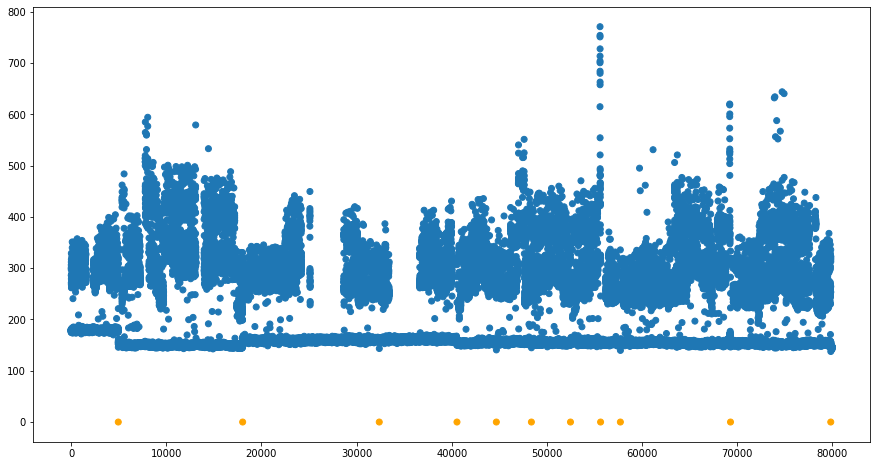

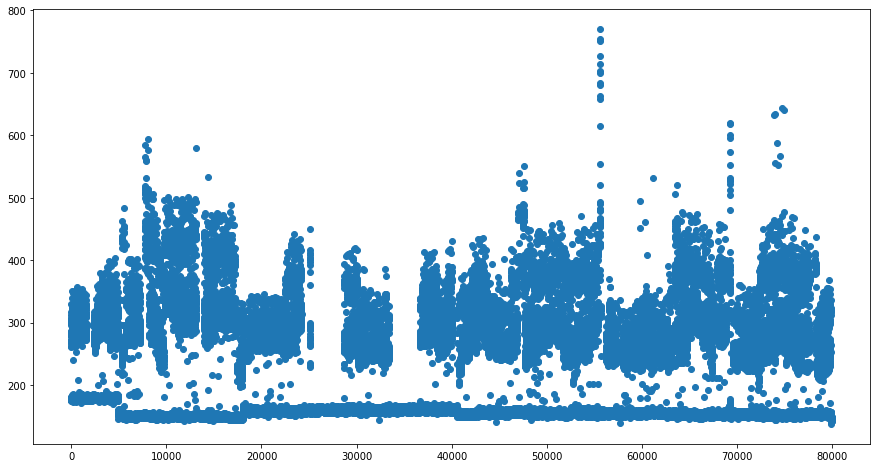

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

plc_data0 = pd.read_csv("/gdrive/My Drive/file/ROUGHING_MILL_STAND10_ACTUAL_CURRENT_sample.csv", parse_dates=['srvtime'], infer_datetime_format=True)
print(tabulate(plc_data0.head(), headers='keys', tablefmt='psql'))

# 1 : check scatter graph
plc_data1 = plc_data0[(plc_data0['srvtime'].dt.strftime('%Y-%m-%d %H') >= '2021-03-01 01') & (plc_data0['srvtime'].dt.strftime('%Y-%m-%d %H') <= '2021-03-02 03')]
plc_data1.info()
color = ['#1f77b4' if x > 10 else 'orange' for x in plc_data1['value']]
idx = range(1, len(plc_data1) + 1)
plt.figure(figsize=(15,8))
plt.scatter(idx, plc_data1['value'], c=color)
plt.show()

# 2 : remove row if < 10
plc_data2 = plc_data1[plc_data1['value'] >= 10]
idx = range(1, len(plc_data2) + 1)
plt.figure(figsize=(15,8))
plt.scatter(idx, plc_data2['value'])
plt.show()

# 3 : rpca
plc_data3 = plc_data2.iloc[:, 2]

# AnomalyDetection_RPCA


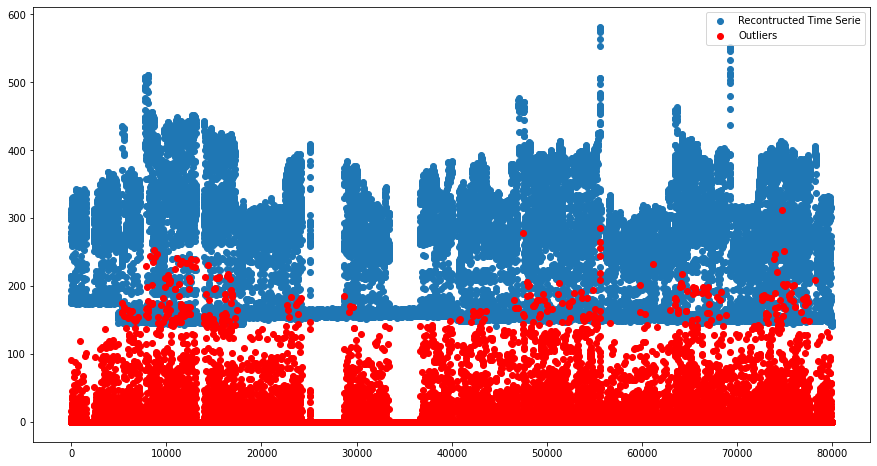

In [7]:
Mod1 = AnomalyDetection_RPCA(verbose=False)
Mod1.fit(X=plc_data3)
outliers = Mod1.get_outliers()
outliers = Mod1.decision_function()
L,S,E = Mod1.transform()
# recon['value'] = L + E
# recon['idx'] = range(1, len(recon) + 1)
idx2 = range(1, len(L+E) + 1)
plt.figure(figsize=(15,8))
plt.scatter(idx2, L+E, c='#1f77b4',label='Recontructed Time Serie')
plt.scatter(idx2, np.abs(S), c='red',label='Outliers')
plt.legend()
plt.show()

# inexact_augmented_lagrange_multiplier